In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(ggpubr)
library(ggthemes) 
library(ggplot2)
library(ComplexHeatmap)
library(circlize)

theme_Publication <- function(base_size=20, base_family="") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_line(colour="#f0f0f0"),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.5, "cm"),
               legend.margin = unit(0, "cm"),
#                legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

scale_fill_Publication <- function(...){
      library(scales)
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad',"#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad')), ...)
}

scale_fill_Publication_continuous <- function(...){
      library(scales)
      continuous_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad')), ...)
}

scale_colour_Publication <- function(...){
      library(scales)
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506",
                                                                  "#a6cee3","#fb9a99","#984ea3","#ffff33",'#6060f4','#ad27ad')), ...)
}

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: grid

R[write to console]: ========================================
ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


R[write to console]: ========================================
circlize version 0.4.15
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Document

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import pandas as pd
import numpy as np
from collections import defaultdict
from multiprocessing import Pool

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import scipy
from statsmodels.stats.multitest import multipletests

import scanpy as sc
import anndata
import scvelo as scv

from joblib import dump, load

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import * # roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelBinarizer
from functools import partial

os.chdir('/home/wdeng3/workspace/Codespace/scRTE/scripts/')

dataset='../data/all_datasets/AD_HS_00001.cell_exp.txt'
rmsk_f='../../universal_data/rmsk/rmsk_GRCh38.txt'
dataset_umap='../data/all_datasets/AD_HS_00001.cell_umap.txt'
gtf='../../universal_data/ref/GRCh38/gencode.v43.basic.annotation.gtf'
input_path='../data/all_datasets/'

gene_type={}
for line in open(gtf):
    if not line.startswith('#'):
        info=line.strip().split('\t')
        if info[2]=='gene':
            split_='gene_name "' if 'gene_name' in info[-1] else 'gene_id "'
            gene_name=info[-1].split(split_)[1].split('"')[0]
            if 'lncRNA' in info[-1] :
                gene_type[gene_name]='lncRNA'
            elif 'protein_coding' in info[-1]:
                gene_type[gene_name]='protein_coding'
            elif 'pseudogene' in info[-1]:
                gene_type[gene_name]='pseudogene'
            else:
                gene_type[gene_name]='Others'
            
rmsk=pd.read_csv(rmsk_f,sep='\t')
rmsk['repFamily']=[x.replace('?','') for x in rmsk['repFamily']]
rmsk['repLen']=rmsk['genoEnd']-rmsk['genoStart']
classification=rmsk.loc[rmsk['repClass'].isin(['SINE', 'LINE', 'LTR']),['repName','repClass','repFamily']].drop_duplicates(ignore_index=True)
tmp=rmsk.iloc[:,[10,11]].drop_duplicates()
te_cls=dict(zip(tmp['repName'],tmp['repClass']))
tmp=rmsk.iloc[:,[10,11,12]].drop_duplicates()
tmp=tmp.loc[tmp['repClass'].isin(['SINE','LINE','LTR']),:]
te_fam=dict(zip(tmp['repName'],tmp['repFamily']))
fam_te=defaultdict(list)
for x in te_fam:
    fam_te[te_fam[x]].append(x)
gene_type.update(te_cls)
rtes=rmsk['repName'].unique()

genes=list(gene_type.keys())
genes_rep=[x.replace('_','.').replace('-','.') for x in genes]
file_list=[x for x in os.listdir(input_path) if x.endswith('.cell_exp.txt')]

def get_dataset(dataset):
    print(f'loading data: {dataset} \n')
    dt_ls=[x for x in file_list if x.startswith(dataset)]
    print('Reading %s \n'%os.path.join(input_path,dt_ls[0]))
    cell_exp=pd.read_table(os.path.join(input_path,dt_ls[0]),index_col=0)
    if len(dt_ls) >1:
        cell_umap=pd.read_table(f'{input_path}/{dataset}.1.cell_umap.txt',index_col=0)
        for i in range(1,len(dt_ls)):
            print('Reading %s \n'%os.path.join(input_path,dt_ls[i]))
            cell_exp=pd.concat([cell_exp,pd.read_table(f'{input_path}/'+dt_ls[i],index_col=0)])
            cell_umap=pd.concat([cell_umap,pd.read_table(f'{input_path}/{dataset}.{i}.cell_umap.txt',index_col=0)])
    else:
        cell_umap=pd.read_table(f'{input_path}/'+dataset+'.cell_umap.txt',index_col=0)
    
    cell_umap['predicted.celltype'] = cell_umap['predicted.celltype'].replace(
        'Opc', 'OPC')
    for i in range(cell_umap.shape[0]):
        if cell_umap.iloc[i,1] =='Stage_0':
            cell_umap.iloc[i,1]='Control'
        if cell_umap.iloc[i,1] !='Control' and  not cell_umap.iloc[i,1].startswith('Stage'):
            cell_umap.iloc[i,1]=cell_umap.iloc[i,7].split('_')[0]
    
    colnames=cell_exp.columns
    repl_colnames=[]
    for x in colnames:
        if '.' not in x or x not in genes_rep:
            repl_colnames.append(x)
        else:
            repl_colnames.append(genes[genes_rep.index(x)])
    cell_exp.columns=repl_colnames
    print(f'Done loading: {dataset} \n')
    return [cell_exp,dataset,cell_umap]

def get_dataset_nomerge(dataset):
    print(f'loading data: {dataset} \n')
    cell_exp=pd.read_table(f'{input_path}/{dataset}.cell_exp.txt',index_col=0)
    cell_umap=pd.read_table(f'{input_path}/{dataset}.cell_umap.txt',index_col=0)
    
    cell_umap['predicted.celltype'] = cell_umap['predicted.celltype'].replace(
        'Opc', 'OPC')
    for i in range(cell_umap.shape[0]):
        if cell_umap.iloc[i,1] =='Stage_0':
            cell_umap.iloc[i,1]='Control'
        if cell_umap.iloc[i,1] !='Control' and  not cell_umap.iloc[i,1].startswith('Stage'):
            cell_umap.iloc[i,1]=cell_umap.iloc[i,7].split('_')[0]
    
    colnames=cell_exp.columns
    repl_colnames=[]
    for x in colnames:
        if '.' not in x or x not in genes_rep:
            repl_colnames.append(x)
        else:
            repl_colnames.append(genes[genes_rep.index(x)])
    cell_exp.columns=repl_colnames
    print(f'Done loading: {dataset} \n')
    return [cell_exp,dataset,cell_umap]




## Disease stage inference from RTE expression

In [4]:
# sfg_ad=all_dfs['AD_HS_00003.1'].copy()
# sfg_umap=all_cell_umaps['AD_HS_00003.1'].copy()
sfg_ad=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_exp.txt',sep='\t',index_col=0)
sfg_umap=pd.read_csv('../data/all_datasets/AD_HS_00003.1.cell_umap.txt',sep='\t',index_col=0)
colnames=sfg_ad.columns
repl_colnames=[]
for x in colnames:
    if '.' not in x or x not in genes_rep:
        repl_colnames.append(x)
    else:
        repl_colnames.append(genes[genes_rep.index(x)])

sfg_ad.columns=repl_colnames

sfg_ad['Diagnosis']=sfg_umap['Diagnosis']
sfg_ad['predicted.celltype']=sfg_umap['predicted.celltype']
sfg_ad['UMAP_1']=sfg_umap['UMAP_1']
sfg_ad['UMAP_2']=sfg_umap['UMAP_2']

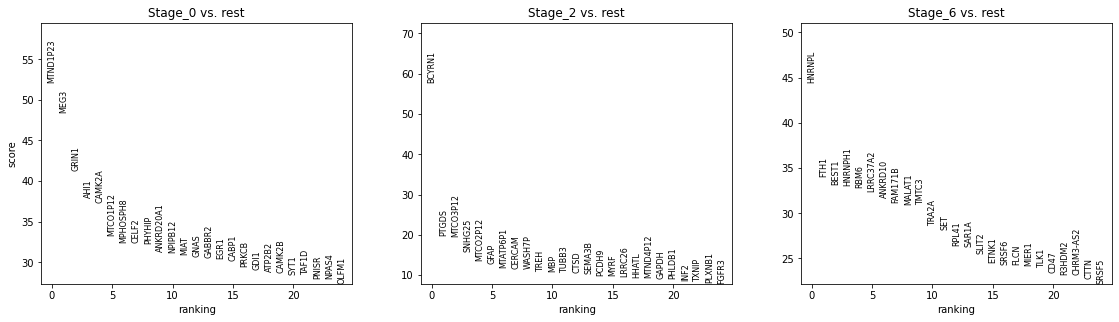

In [5]:
ex_=sfg_ad.loc[sfg_ad['predicted.celltype']=='Ex',[x for x in sfg_ad.columns if x not in rtes]]
adata=anndata.AnnData(X=np.expm1(ex_.iloc[:,:-4]))

adata.obs['Diagnosis']=ex_['Diagnosis']
adata.obs['CellType']=ex_['predicted.celltype']
adata.obsm['X_umap']=ex_[['UMAP_1','UMAP_2']].to_numpy()
adata.var["mito"] = adata.var_names.str.startswith("MT-")
adata.layers["counts"] = adata.X.copy()
sc.pp.calculate_qc_metrics(adata, qc_vars=["mito"], inplace=True)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
# fig,axs=plt.subplots(1,3,figsize=[45,8])

non_mito=np.invert(adata.var_names.str.startswith("MT-"))
adata=adata[:,non_mito]
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata)
sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata, color='CellType')
sc.tl.rank_genes_groups(adata, 'Diagnosis', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
gene_markers=[]
marker_list=np.array(adata.uns['rank_genes_groups']['names'].tolist()).flatten()
for i in marker_list:
    if i not in gene_markers:
        gene_markers.append(i)
extended_markers=gene_markers[:730*2]
gene_markers=gene_markers[:730]

### Compare ML models

In [ ]:

def cv_auc(classifiers,names,x,y,feature_name,index):
    scaler = StandardScaler()
    classifier,model_name=classifiers[index],names[index]
    folds=[10] 

    font1 = {'family' : 'Arial',
            'weight' : 'normal',
            'size'   : 16}      
    figsize=6.2, 6.2
    figure, ax = plt.subplots(figsize=figsize)
    
    plt.tick_params(labelsize=18)
    plt_labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Arial') for label in plt_labels]
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Luck', alpha=.8)

    for k in folds:
        kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)   
        y_onehot=[]
        y_scores=[]
        for train,test in kfold.split(x, y):
            print('train: %s, test: %s' % (train, test))
            x[train] = scaler.fit_transform(x[train])
            x[test] = scaler.transform(x[test])
            label_binarizer = LabelBinarizer().fit(y[train])
            y_onehot_test = label_binarizer.transform(y[test])

            classifier.fit(x[train], 
                            y[train])
            probas_ = classifier.predict_proba(x[test])      
            y_onehot.extend(y_onehot_test.ravel())
            y_scores.extend(probas_.ravel()) 

        display = RocCurveDisplay.from_predictions(
            y_onehot,
            y_scores,
            name="%s-fold"%k,
            color="darkorange",
        )
        display.plot(ax=ax)

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', font1)
    plt.ylabel('True Positive Rate', font1)
    title='Micro-average OvR ROC Curve'
    plt.title(title, font1)
    plt.legend(loc="lower right")
    if not os.path.isdir('../data/analysis/models_%s'%feature_name):
        os.mkdir('../data/analysis/models_%s'%feature_name)
    plt.savefig( '../data/analysis/models_%s/%s_CV_roc.pdf' % (feature_name,model_name), dpi=300, bbox_inches = 'tight')
    # plt.show()
    return ['%s_%s'%(model_name, feature_name),y_onehot,y_scores]

#### RTE only

In [38]:
### Prepare data
cell='Ex'
cell_exp=sfg_ad.loc[sfg_ad['predicted.celltype']==cell,:]
cell_exp.iloc[:,:-4]=np.expm1(cell_exp.iloc[:,:-4].astype(float))
rte_exp=cell_exp[[x for x in cell_exp.columns if x in rtes]]
factors=pd.factorize(cell_exp['Diagnosis'])
labels=factors[0]

### Define models
classifiers = [
    SVC(decision_function_shape='ovr',random_state=42,probability=True),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(n_estimators=100,random_state=42),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))]

names = [
    "RBF SVM",
    "Random Forest",
    "AdaBoost",
    "MLP"
]

### Cross validation
func_=partial(cv_auc,classifiers,names,rte_exp.to_numpy(),labels,'RTE730')

pool=Pool(4) 
ret=pool.map(func_,range(4))
pool.close()
pool.join()

### Indenpendent testing
definitions=factors[1]
x_train,x_test,y_train,y_test = train_test_split(rte_exp.to_numpy(),labels,test_size=0.2,random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


if True:# not os.path.isfile(f'../data/analysis/models/{names[0]}_RTE.joblib'):
    for i in range(len(classifiers)):
        cls = classifiers[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_RTE.joblib')
else:
    classifiers=[load(f'../data/analysis/models/{names[i]}_RTE.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
t_labels=['Stage_6','Stage_2','Stage_0']
for i in range(len(classifiers)):
    cls = classifiers[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_rte_cm.csv',index=True,header=True)

In [16]:
%%R
ps<-list()
pdf('../data/analysis/figures/rte_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     print(name)
     df<-read.csv(paste0('../data/analysis/models/',name,'_rte_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
          cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
          show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
          bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
          show_row_names = FALSE,
          heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
          rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     print(p)
}

dev.off()

[1] "RBF SVM"
[1] "Random Forest"
[1] "AdaBoost"
[1] "MLP"
png 
  2 


In [17]:
importances = classifiers[1].feature_importances_
importances=pd.Series(importances, index=rte_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers[1].estimators_], axis=0),index=rte_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/rte_importances.csv',index=True,header=True)

png 
  2 


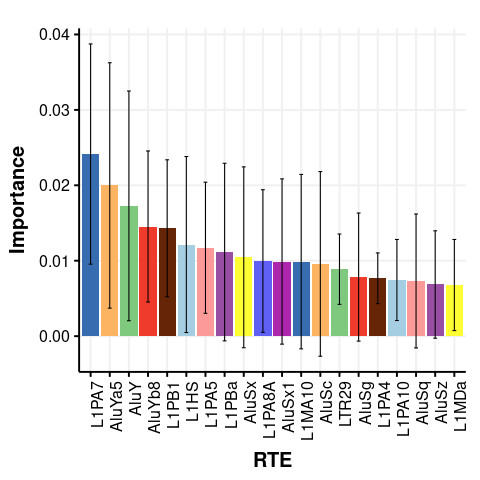

In [18]:
%%R
df<-read.csv('../data/analysis/rte_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Importance')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/rte_importances.pdf')
print(p)
dev.off()

#### Gene only

In [19]:
gene_exp=cell_exp.loc[:,gene_markers]

### Define models
classifiers_gene= [
    SVC(decision_function_shape='ovr',random_state=42),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
func_=partial(cv_auc,classifiers_gene,names,gene_exp.to_numpy(),labels,'Gene730')

pool=Pool(4) 
ret=pool.map(func_,range(4))
pool.close()
pool.join()

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(gene_exp.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

if not os.path.isfile(f'../data/analysis/models/{names[0]}_gene.joblib'):

    for i in range(len(classifiers_gene)):
        cls = classifiers_gene[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_gene.joblib')
else:
    classifiers_gene=[load(f'../data/analysis/models/{names[i]}_gene.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
t_labels=['Stage_6','Stage_2','Stage_0']
for i in range(len(classifiers_gene)):
    cls = classifiers_gene[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_gene_cm.csv',index=True,header=True)

RBF SVM 0.847457627118644 22420 7561 8373 6486
Random Forest 0.8307314897413024 22420 7561 8373 6486
AdaBoost 0.7636039250669046 22420 7561 8373 6486
MLP 0.8592774308652988 22420 7561 8373 6486


In [20]:
%%R
ps<-list()
pdf('../data/analysis/figures/gene_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     df<-read.csv(paste0('../data/analysis/models/',name,'_gene_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
             cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
             show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
             bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
             show_row_names = FALSE,
        heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
        rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     draw(p)
     ps[[length(ps)+1]]<-p
#      break
}
# for(p in ps){
#     draw(p)
# }
dev.off()

png 
  2 


In [21]:
importances = classifiers_gene[1].feature_importances_
importances=pd.Series(importances, index=gene_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers_gene[1].estimators_], axis=0),
                                              index=gene_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/gene_importances.csv',index=True,header=True)

png 
  2 


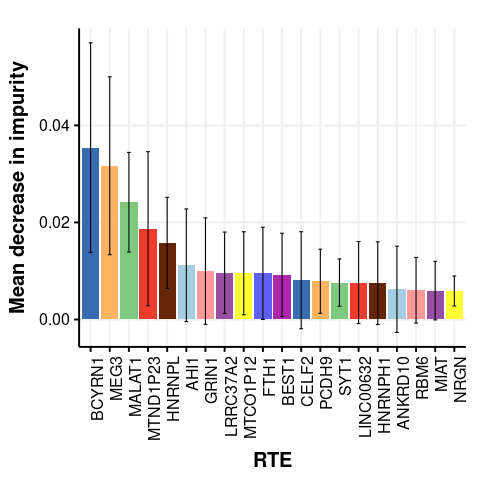

In [22]:
%%R
df<-read.csv('../data/analysis/gene_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/gene_importances.pdf')
print(p)
dev.off()

#### Combine gene and RTE

In [23]:
combined_exp=cell_exp.loc[:,[x for x in cell_exp.columns if x in rtes]+gene_markers]

### Define models
classifiers_combined= [
    SVC(decision_function_shape='ovr',random_state=42),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
func_=partial(cv_auc,classifiers_combined,names,combined_exp.to_numpy(),labels,'Combined')

pool=Pool(4) 
ret=pool.map(func_,range(4))
pool.close()
pool.join()

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(combined_exp.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

if True:#not os.path.isfile(f'../data/analysis/models/{names[0]}_combined.joblib'):

    for i in range(len(classifiers_combined)):
        cls = classifiers_combined[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_combined.joblib')
# else:
#     classifiers_combined=[load(f'../data/analysis/models/{names[i]}_combined.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
for i in range(len(classifiers_combined)):
    cls = classifiers_combined[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_combined_cm.csv',index=True,header=True)

RBF SVM 0.8623996431757359 22420 7561 8373 6486
Random Forest 0.8099910793933988 22420 7561 8373 6486
AdaBoost 0.7607047279214987 22420 7561 8373 6486
MLP 0.8704281891168599 22420 7561 8373 6486


In [24]:
%%R
ps<-list()
pdf('../data/analysis/figures/combined_cm.pdf')

for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     df<-read.csv(paste0('../data/analysis/models/',name,'_combined_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
             cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
             show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
             bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
             show_row_names = FALSE,
        heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
        rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     draw(p)
     ps[[length(ps)+1]]<-p
#      break
}
# for(p in ps){
#     print(p)
# }
dev.off()


png 
  2 


In [25]:
importances = classifiers_combined[1].feature_importances_
importances=pd.Series(importances, index=combined_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers_combined[1].estimators_], axis=0),index=combined_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/combined_importances.csv',index=True,header=True)

png 
  2 


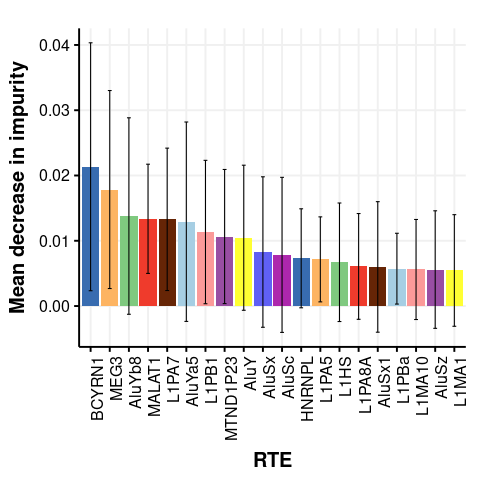

In [26]:
%%R
df<-read.csv('../data/analysis/combined_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/combined_importances.pdf')
print(p)
dev.off()

### Use extended gene list (top 730x2)

In [27]:
gene_exp2=cell_exp.loc[:,extended_markers]

### Define models
classifiers_gene2= [
    SVC(decision_function_shape='ovr',random_state=42),
    RandomForestClassifier(n_estimators=100,random_state=42),
    AdaBoostClassifier(),
    MLPClassifier(alpha=1, max_iter=10000,random_state=42,hidden_layer_sizes=(1000,1000))
]

### Cross validation
func_=partial(cv_auc,classifiers_gene2,names,gene_exp2.to_numpy(),labels,'Combined')

pool=Pool(4) 
ret=pool.map(func_,range(4))
pool.close()
pool.join()

### Independent testing
x_train,x_test,y_train,y_test = train_test_split(gene_exp2.to_numpy(),labels,test_size=0.2,random_state=42)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

if True:#not os.path.isfile(f'../data/analysis/models/{names[0]}_combined.joblib'):
    for i in range(len(classifiers_gene2)):
        cls = classifiers_combined[i]
        cls.fit(x_train, y_train)
        dump(cls, f'../data/analysis/models/{names[i]}_extended.joblib')
# else:
#     classifiers_combined=[load(f'../data/analysis/models/{names[i]}_combined.joblib') for i in range(len(names))]

# model name, predicted label, true label, count
pre_labels=['Stage_0','Stage_2','Stage_6']
for i in range(len(classifiers_gene2)):
    cls = classifiers_gene2[i]
    name=names[i]
    y_pred=cls.predict(x_test)
    print(name,accuracy_score(y_test, y_pred),len(labels),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_0',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_2',:]),len(cell_exp.loc[cell_exp['Diagnosis']=='Stage_6',:]))
    cm=confusion_matrix(y_test,y_pred)
    pd.DataFrame(cm,columns=pre_labels,index=pre_labels).to_csv(f'../data/analysis/models/{names[i]}_extended_cm.csv',index=True,header=True)

RBF SVM 0.8521409455842998 22420 7561 8373 6486
Random Forest 0.8146743978590544 22420 7561 8373 6486
AdaBoost 0.760035682426405 22420 7561 8373 6486
MLP 0.8588314005352364 22420 7561 8373 6486


In [29]:
%%R
pdf('../data/analysis/figures/extended_cm.pdf')
# ps<-list()
for(name in c("RBF SVM","Random Forest","AdaBoost","MLP")){
     print(name)
     df<-read.csv(paste0('../data/analysis/models/',name,'_extended_cm.csv'),row.names=1)
     p<-Heatmap(df,cluster_columns=F,cluster_rows=F,column_title="Predicted label",column_title_gp = gpar(fontsize = 25),row_title='True label',row_title_gp = gpar(fontsize = 25),
             cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%s", df[i, j]), x, y, gp = gpar(color='white',fontsize = 20))},
             show_column_names = FALSE, col = colorRamp2(c(0,1000,1600), c("#44A1F2", "#BBEFFF", "#D18D93")),
             bottom_annotation = HeatmapAnnotation(text = anno_text(colnames(df), rot=0,just='center',location=0,gp=gpar(fontsize=18))),
             show_row_names = FALSE,
        heatmap_legend_param=list(title='Count',legend_height=unit(10,'cm'),at=c(0,1000,1600), grid_width = unit(1, "cm"),title_gp=gpar(fontsize=18),labels_gp = gpar(fontsize=16)))+
        rowAnnotation(text = anno_text(colnames(df), rot=90,just='center', location=0.5,gp=gpar(fontsize=18)))
     draw(p)
     ps[[length(ps)+1]]<-p
}

dev.off()

[1] "RBF SVM"
[1] "Random Forest"
[1] "AdaBoost"
[1] "MLP"
png 
  2 


In [30]:
importances = classifiers_combined[1].feature_importances_
importances=pd.Series(importances, index=combined_exp.columns)
importances=pd.concat([importances, pd.Series(np.std([tree.feature_importances_ for tree in classifiers_combined[1].estimators_], axis=0),index=combined_exp.columns)], axis=1)
importances.columns=['Importance','STD']

importances=importances.sort_values(by='Importance',ascending=False)
importances_=importances.iloc[:20,:]
importances_.to_csv('../data/analysis/extended_importances.csv',index=True,header=True)

png 
  2 


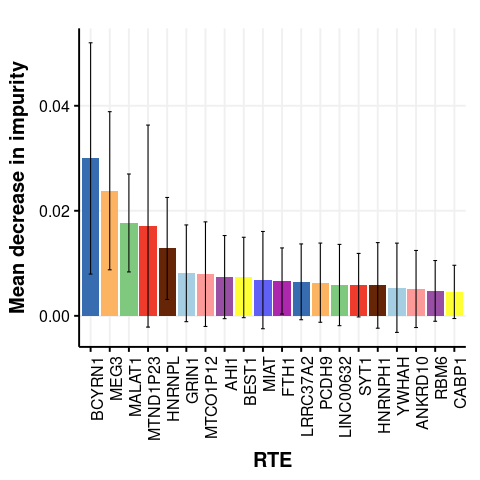

In [31]:
%%R
df<-read.csv('../data/analysis/extended_importances.csv')
df$X<-factor(df$X,levels=df$X[order(df$Importance,decreasing=T)])
p<-ggplot(data=df,aes(x=X,y=Importance,fill=X))+geom_bar(stat='identity')+theme_Publication()+scale_fill_Publication()+theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position='none')+xlab('RTE')+ylab('Mean decrease in impurity')+
 geom_errorbar(aes(ymin=Importance-STD, ymax=Importance+STD), width=.2,position=position_dodge(.9)) 
print(p)
pdf('../data/analysis/figures/extended_importances.pdf')
print(p)
dev.off()